<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подключение-библиотек" data-toc-modified-id="Подключение-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подключение библиотек</a></span></li><li><span><a href="#Статистический-анализ" data-toc-modified-id="Статистический-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Статистический анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Поле-Age" data-toc-modified-id="Поле-Age-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Поле Age</a></span><ul class="toc-item"><li><span><a href="#Тестирование-поля-Age-на-лог-нормальное-распределения" data-toc-modified-id="Тестирование-поля-Age-на-лог-нормальное-распределения-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Тестирование поля Age на лог-нормальное распределения</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Тест-хи-квадрат" data-toc-modified-id="Тест-хи-квадрат-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Тест хи-квадрат</a></span></li><li><span><a href="#Тест-Колмагорова-—-Смирнова" data-toc-modified-id="Тест-Колмагорова-—-Смирнова-3.2.2.2"><span class="toc-item-num">3.2.2.2&nbsp;&nbsp;</span>Тест Колмагорова — Смирнова</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Поле-Product" data-toc-modified-id="Поле-Product-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Поле Product</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Анализ-предпочтение-пользователей-в-зависимости-от-возраста" data-toc-modified-id="Анализ-предпочтение-пользователей-в-зависимости-от-возраста-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Анализ предпочтение пользователей в зависимости от возраста</a></span><ul class="toc-item"><li><span><a href="#Тест-ANOVA" data-toc-modified-id="Тест-ANOVA-3.3.2.1"><span class="toc-item-num">3.3.2.1&nbsp;&nbsp;</span>Тест ANOVA</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Поле-Gender" data-toc-modified-id="Поле-Gender-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Поле Gender</a></span><ul class="toc-item"><li><span><a href="#Анализ-предпочтение-пользователей-в-зависимости-от-пола" data-toc-modified-id="Анализ-предпочтение-пользователей-в-зависимости-от-пола-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Анализ предпочтение пользователей в зависимости от пола</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4.1.1"><span class="toc-item-num">3.4.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-возраста-пользователей-беговых-дорожек-в-разбивки-по-грейдерному-признаку" data-toc-modified-id="Анализ-возраста-пользователей-беговых-дорожек-в-разбивки-по-грейдерному-признаку-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Анализ возраста пользователей беговых дорожек в разбивки по грейдерному признаку</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4.3"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Поле-Education" data-toc-modified-id="Поле-Education-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Поле Education</a></span><ul class="toc-item"><li><span><a href="#Анализ-влияние-образования-на-выбор-типа-продукта" data-toc-modified-id="Анализ-влияние-образования-на-выбор-типа-продукта-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Анализ влияние образования на выбор типа продукта</a></span></li><li><span><a href="#Анализ-в-предположении,-что-Education---категориальная-переменная" data-toc-modified-id="Анализ-в-предположении,-что-Education---категориальная-переменная-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Анализ в предположении, что Education - категориальная переменная</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5.2.1"><span class="toc-item-num">3.5.2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-в-предположении,-что-Education---непрерывная-переменная" data-toc-modified-id="Анализ-в-предположении,-что-Education---непрерывная-переменная-3.5.3"><span class="toc-item-num">3.5.3&nbsp;&nbsp;</span>Анализ в предположении, что Education - непрерывная переменная</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5.3.1"><span class="toc-item-num">3.5.3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-влияние-образования-на-возраст" data-toc-modified-id="Анализ-влияние-образования-на-возраст-3.5.4"><span class="toc-item-num">3.5.4&nbsp;&nbsp;</span>Анализ влияние образования на возраст</a></span></li><li><span><a href="#Анализ-влияние-образования-на-пол" data-toc-modified-id="Анализ-влияние-образования-на-пол-3.5.5"><span class="toc-item-num">3.5.5&nbsp;&nbsp;</span>Анализ влияние образования на пол</a></span></li><li><span><a href="#Анализ-в-предположении,-что-Education---категориальная-переменная" data-toc-modified-id="Анализ-в-предположении,-что-Education---категориальная-переменная-3.5.6"><span class="toc-item-num">3.5.6&nbsp;&nbsp;</span>Анализ в предположении, что Education - категориальная переменная</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5.6.1"><span class="toc-item-num">3.5.6.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-в-предположении,-что-Education---непрерывная-переменная" data-toc-modified-id="Анализ-в-предположении,-что-Education---непрерывная-переменная-3.5.7"><span class="toc-item-num">3.5.7&nbsp;&nbsp;</span>Анализ в предположении, что Education - непрерывная переменная</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5.7.1"><span class="toc-item-num">3.5.7.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Поле-MaritalStatus" data-toc-modified-id="Поле-MaritalStatus-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Поле MaritalStatus</a></span><ul class="toc-item"><li><span><a href="#Анализ-влияние-семейного-положения-на-выбор-типа-продукта" data-toc-modified-id="Анализ-влияние-семейного-положения-на-выбор-типа-продукта-3.6.1"><span class="toc-item-num">3.6.1&nbsp;&nbsp;</span>Анализ влияние семейного положения на выбор типа продукта</a></span></li><li><span><a href="#Распределение-возраста-в-разбивки-по-семейному-положению" data-toc-modified-id="Распределение-возраста-в-разбивки-по-семейному-положению-3.6.2"><span class="toc-item-num">3.6.2&nbsp;&nbsp;</span>Распределение возраста в разбивки по семейному положению</a></span></li><li><span><a href="#Распределения-семейного-положения-в-разбивки-по-гендерному-признаку" data-toc-modified-id="Распределения-семейного-положения-в-разбивки-по-гендерному-признаку-3.6.3"><span class="toc-item-num">3.6.3&nbsp;&nbsp;</span>Распределения семейного положения в разбивки по гендерному признаку</a></span></li><li><span><a href="#Анализ-влияние-семейного-положение-на-образование" data-toc-modified-id="Анализ-влияние-семейного-положение-на-образование-3.6.4"><span class="toc-item-num">3.6.4&nbsp;&nbsp;</span>Анализ влияние семейного положение на образование</a></span></li></ul></li><li><span><a href="#Поле-Usage" data-toc-modified-id="Поле-Usage-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Поле Usage</a></span><ul class="toc-item"><li><span><a href="#Анализ-выбора-типа-дорожки-в-зависимости-от-планов-на-использования" data-toc-modified-id="Анализ-выбора-типа-дорожки-в-зависимости-от-планов-на-использования-3.7.1"><span class="toc-item-num">3.7.1&nbsp;&nbsp;</span>Анализ выбора типа дорожки в зависимости от планов на использования</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.7.1.1"><span class="toc-item-num">3.7.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-планов-на-использование-в-зависимости-от-возраста" data-toc-modified-id="Анализ-планов-на-использование-в-зависимости-от-возраста-3.7.2"><span class="toc-item-num">3.7.2&nbsp;&nbsp;</span>Анализ планов на использование в зависимости от возраста</a></span></li><li><span><a href="#Анализ-планов-на-использование-в-зависимости-от-пола" data-toc-modified-id="Анализ-планов-на-использование-в-зависимости-от-пола-3.7.3"><span class="toc-item-num">3.7.3&nbsp;&nbsp;</span>Анализ планов на использование в зависимости от пола</a></span></li><li><span><a href="#Анализ-планов-на-использование-в-зависимости-от-образования" data-toc-modified-id="Анализ-планов-на-использование-в-зависимости-от-образования-3.7.4"><span class="toc-item-num">3.7.4&nbsp;&nbsp;</span>Анализ планов на использование в зависимости от образования</a></span></li><li><span><a href="#Анализ-планов-на-использование-в-зависимости-от-семейного-положения" data-toc-modified-id="Анализ-планов-на-использование-в-зависимости-от-семейного-положения-3.7.5"><span class="toc-item-num">3.7.5&nbsp;&nbsp;</span>Анализ планов на использование в зависимости от семейного положения</a></span></li></ul></li><li><span><a href="#Поле-Fitness" data-toc-modified-id="Поле-Fitness-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Поле Fitness</a></span><ul class="toc-item"><li><span><a href="#Влияние-оценки-физической-формы-на-тип-продукта" data-toc-modified-id="Влияние-оценки-физической-формы-на-тип-продукта-3.8.1"><span class="toc-item-num">3.8.1&nbsp;&nbsp;</span>Влияние оценки физической формы на тип продукта</a></span></li><li><span><a href="#Влияние-возраста-на-оценку-физической-формы" data-toc-modified-id="Влияние-возраста-на-оценку-физической-формы-3.8.2"><span class="toc-item-num">3.8.2&nbsp;&nbsp;</span>Влияние возраста на оценку физической формы</a></span></li></ul></li></ul></li></ul></div>

# CardioGoodFitness

Статистический анализ данных. Цель выявить типичного пользователя беговой дорожки, а также выяснить отличаются ли пользователи, предпочитающие разные типы беговых дорожек.

## Описание данных 

- Product - тип продукта 
- Age - возраст в годах
- Gender - пол
- Education - образование в годах 
- MaritalStatus - семейный статус 
- Usage - планируют использовать (часы в неделю)
- Fitness - самооценка физической формы по шкале от 1 до 5, где 1 - плохая форма, а 5 - отличная форма. 
- Income - годовой доход
- Miles - планируют пробегать в неделю 

## Подключение библиотек 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plot
import math

## Статистический анализ 

In [2]:
data = pd.read_csv('/datasets/Kaggle/CardioGoodFitness.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product        180 non-null    object
 1   Age            180 non-null    int64 
 2   Gender         180 non-null    object
 3   Education      180 non-null    int64 
 4   MaritalStatus  180 non-null    object
 5   Usage          180 non-null    int64 
 6   Fitness        180 non-null    int64 
 7   Income         180 non-null    int64 
 8   Miles          180 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 12.8+ KB


In [4]:
data.head()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14,Single,3,4,29562,112
1,TM195,19,Male,15,Single,2,3,31836,75
2,TM195,19,Female,14,Partnered,4,3,30699,66
3,TM195,19,Male,12,Single,3,3,32973,85
4,TM195,20,Male,13,Partnered,4,2,35247,47


### Вывод

Данные не содержат пустых значений 

### Поле Age

In [5]:
def continuous_distribution(data, name, name_ru):
    fig = plot.figure(figsize=(20, 10))
    ax1 = plot.subplot2grid((2, 2), (0, 0))
    sns.histplot(data, x=name, ax=ax1).set(
        title='Гистограмма',
        xlabel=name_ru, 
        ylabel='Количество'
    )

    ax1 = plot.subplot2grid((2, 2), (0, 1))
    sns.histplot(data, x=name,  stat="density", ax=ax1).set(
        title='Плотность распределения',
        xlabel=name_ru, 
        ylabel='Плотность'
    )

    ax1 = plot.subplot2grid((2, 2), (1, 0), colspan=2)

    ax1.xaxis.grid(True)
    sns.boxplot(x=data[name], ax=ax1).set(
        title='Диаграмма размаха',  
        xlabel=name_ru, 
        ylabel=''
    )
    plot.show()

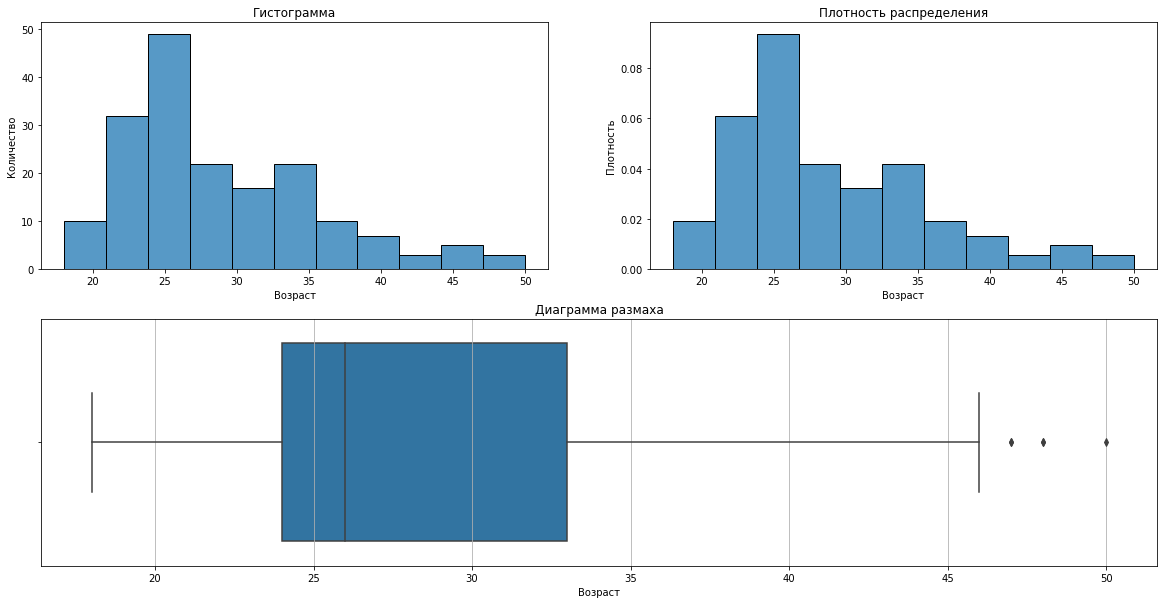

In [6]:
continuous_distribution(data, 'Age', 'Возраст')

Поле содержит небольшое количества выбросов после 45 лет (не многие люди бегают после этого возраста) и предположительно имеет лог-нормальное распределение. Проверим наше предположение.

#### Тестирование поля Age на лог-нормальное распределения 

#### Подготовка данных 

In [7]:
data['Age'].unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 47, 50, 45, 48, 42])

In [8]:
without_outliers = data[data['Age'] < 47]

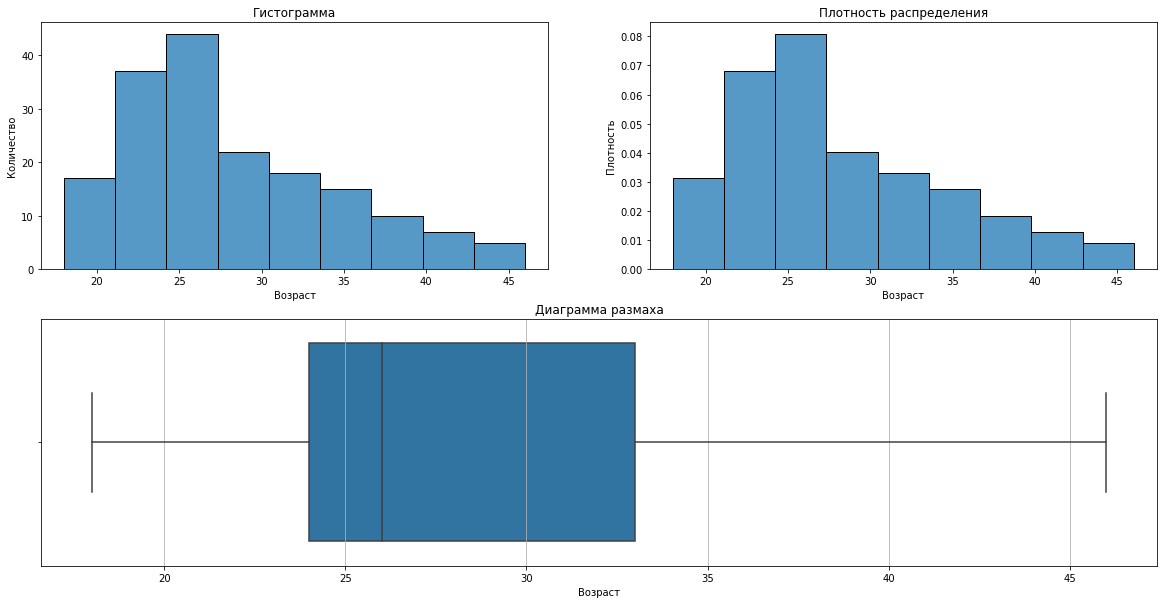

In [9]:
continuous_distribution(without_outliers, 'Age', 'Возраст')

In [10]:
without_outliers['Age'].unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 45, 42])

Данные целочисленные (дискретные), поэтому для проверки гипотезы подойдет хи-квадрат. 

In [11]:
def do_test(p_value, alpha = 0.05):
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Принимаем нулевую гипотезу")

##### Тест хи-квадрат

###### До удаление выбросов 

In [12]:
def do_frequency(values):
    observer_frequency = np.bincount(values)
    
    params = stats.lognorm.fit(values)
    expected_frequency = [len(data) * stats.lognorm.pdf(x, *params) for x in range(values.max() + 1) ]
    expected_frequency = np.array(expected_frequency)
    
    indexes = np.where(expected_frequency == 0)[0]
    observer_frequency = np.delete(observer_frequency, indexes)
    expected_frequency = np.delete(expected_frequency, indexes)
    
    return observer_frequency, expected_frequency

In [13]:
observer_frequency, expected_frequency = do_frequency(data['Age'])

In [14]:
def print_comparing_frequencies(observer_frequency, expected_frequency):
    x = np.arange(len(expected_frequency))  
    width = 0.35 

    fig, ax = plot.subplots(figsize=(15,5))
    ax.bar(x - width/2, observer_frequency, width, label='observer frequency')
    ax.bar(x + width/2, expected_frequency, width, label='expected frequency')

    ax.set_ylabel('Возраст')
    ax.set_title('График сравнения теоретических и наблюдаемых частот ')
    ax.legend()
    
    fig.tight_layout()

    plot.show()

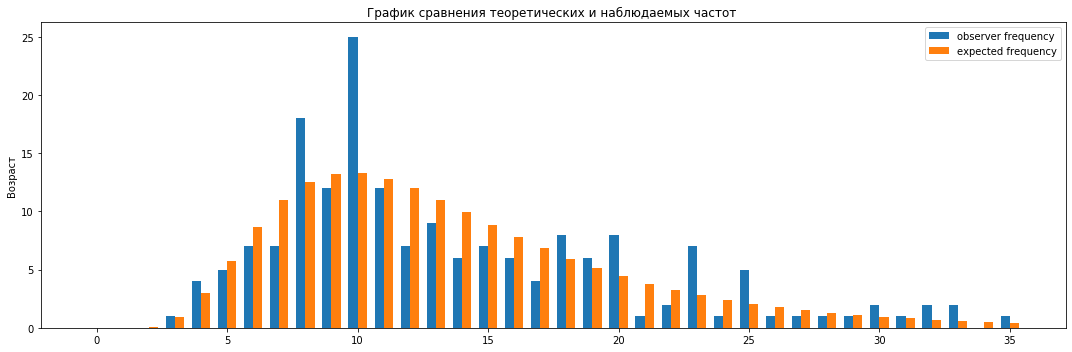

In [15]:
print_comparing_frequencies(observer_frequency, expected_frequency)

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [16]:
result = stats.chisquare(observer_frequency, f_exp=expected_frequency)
result

Power_divergenceResult(statistic=47.79898840803665, pvalue=0.0731463520166491)

In [17]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


###### После удаление выбросов 

In [18]:
observer_frequency, expected_frequency = do_frequency(without_outliers['Age'])

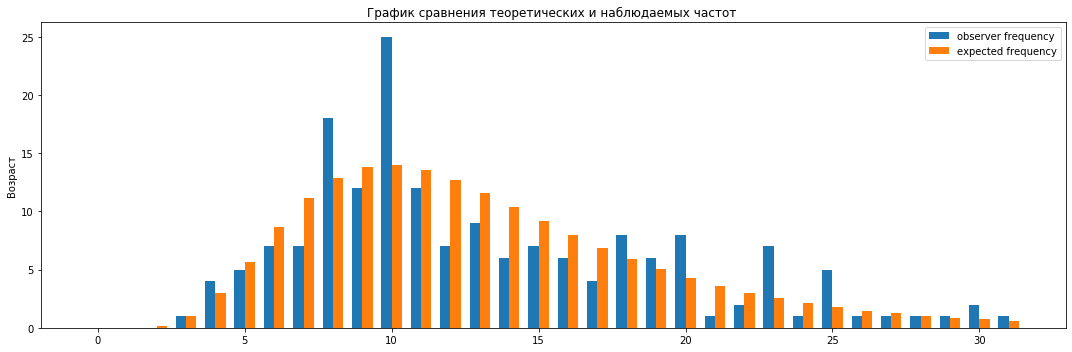

In [19]:
print_comparing_frequencies(observer_frequency, expected_frequency)

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [20]:
result = stats.chisquare(observer_frequency, f_exp=expected_frequency)
result

Power_divergenceResult(statistic=44.475330766195086, pvalue=0.055464544461385844)

In [21]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


##### Тест Колмагорова — Смирнова 

###### До удаление выбросов 

In [22]:
params = stats.lognorm.fit(data['Age'])

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [23]:
result = stats.kstest(data['Age'], stats.lognorm(*params).cdf)

In [24]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


###### После удаление выбросов 

In [25]:
params = stats.lognorm.fit(without_outliers['Age'])

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [26]:
result = stats.kstest(data['Age'], stats.lognorm(*params).cdf)

In [27]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


#### Вывод

Поле Age содержит выбросы (не многие люди бегают после 45 лет) и имеет лог-нормальное распределение. 

### Поле Product  

In [28]:
data['Product'].unique()

array(['TM195', 'TM498', 'TM798'], dtype=object)

In [29]:
def print_categories_variable(colum_name, title, xlabel, ylabel):
    fig = plot.figure(figsize=(20, 5))
    ax1 = plot.subplot2grid((1, 2), (0, 0))
    sns.countplot(x=data[colum_name], ax=ax1).set(
        xlabel=xlabel, 
        ylabel=ylabel
    )

    ax2 = plot.subplot2grid((1, 2), (0, 1))
    
    colum_name2 = 'Product'
    if colum_name == 'Product':
        colum_name2 = 'Gender'

    tmp = data.groupby(colum_name)[colum_name2].count()
    tmp.plot.pie(autopct="%.1f%%", ylabel=xlabel, ax=ax2)
    
    plot.suptitle(title)
    plot.show()

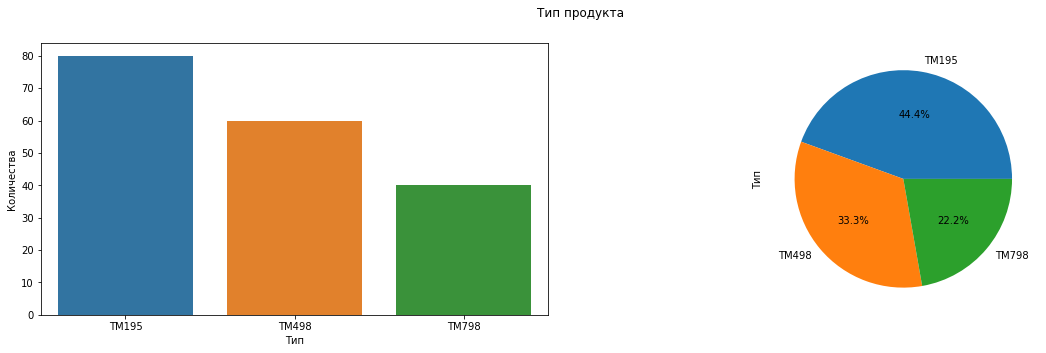

In [30]:
print_categories_variable('Product', 'Тип продукта', 'Тип', 'Количества')

#### Вывод

Пользователи предпочитают беговые дорожки типа TM195

#### Анализ предпочтение пользователей в зависимости от возраста 

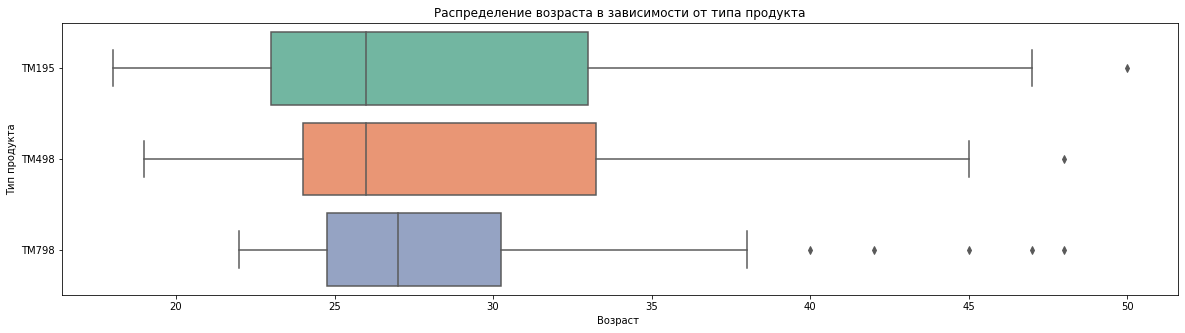

In [31]:
fig = plot.figure(figsize=(20, 5))
sns.boxplot(data=data, x='Age', y='Product', orient="h", palette="Set2").set(
    title='Распределение возраста в зависимости от типа продукта',  
    xlabel='Возраст ', 
    ylabel='Тип продукта'
)
plot.show()

Средний возраст пользователей беговых дорожек типа TM798, выше остальных. Проверим значима ли эти различия.

##### Тест ANOVA

###### До удаление выбросов 

H0 - Средние различаются незначительно

H1 - Различия существенны 

alpha = 0.05

In [32]:
result = stats.f_oneway(data[data['Product'] == 'TM195']['Age'],data[data['Product'] == 'TM498']['Age'],data[data['Product'] == 'TM798']['Age'])

In [33]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


###### После удаление выбросов 

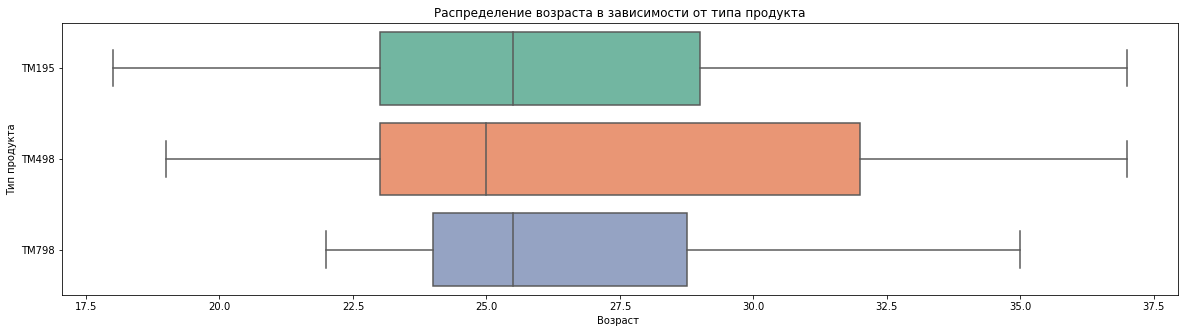

In [34]:
fig = plot.figure(figsize=(20, 5))
tmp = data[data['Age'] < 38]
sns.boxplot(data=tmp, x='Age', y='Product', orient="h", palette="Set2").set(
    title='Распределение возраста в зависимости от типа продукта',  
    xlabel='Возраст ', 
    ylabel='Тип продукта'
)
plot.show()

H0 - Средние различаются незначительно

H1 - Различия существенны 

alpha = 0.05

In [35]:
result = stats.f_oneway(tmp[tmp['Product'] == 'TM195']['Age'], tmp[tmp['Product'] == 'TM498']['Age'], tmp[tmp['Product'] == 'TM798']['Age'])

In [36]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


#### Вывод

Пользователи предпочитают беговые дорожки типа TM195. Возраст не влияет на предпочтения. 

### Поле Gender

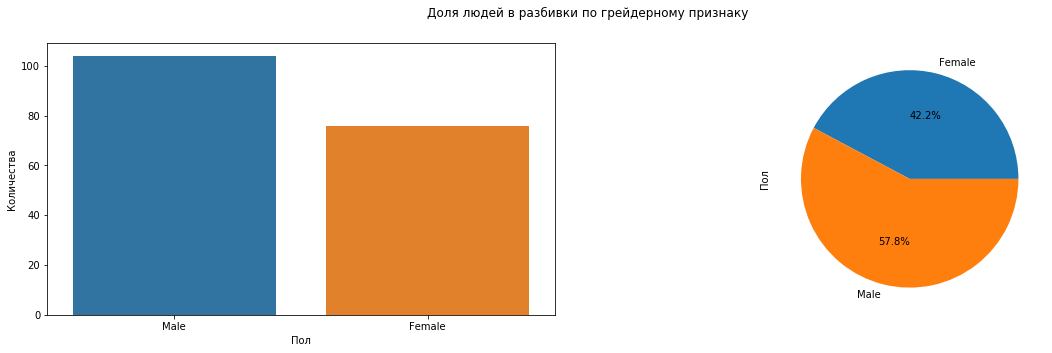

In [37]:
print_categories_variable('Gender', 'Доля людей в разбивки по грейдерному признаку', 'Пол', 'Количества')

use_continuitybool

Среди пользователей беговых дорожек преобладают мужчины

#### Анализ предпочтение пользователей в зависимости от пола

In [38]:
contingency = pd.crosstab(data['Product'], data['Gender'])

In [39]:
contingency

Gender,Female,Male
Product,,
TM195,40,40
TM498,29,31
TM798,7,33


In [40]:
def categorical_compare(contingency, title):
    columns_labels = contingency.columns
    
    rows = len(columns_labels) // 3
    
    columns = 3
    if len(columns_labels) < 3:
        columns = len(columns_labels)     
        rows = 1
        
    fig = plot.figure(figsize=(20, 5 * rows))
    
    for i in range(rows):
        for j in range(columns):
            ax = plot.subplot2grid((rows, columns), (i, j))
            contingency[columns_labels[i*columns + j]].plot.pie(autopct="%.1f%%", ylabel=columns_labels[i*columns + j], ax=ax)
    plot.suptitle(title)

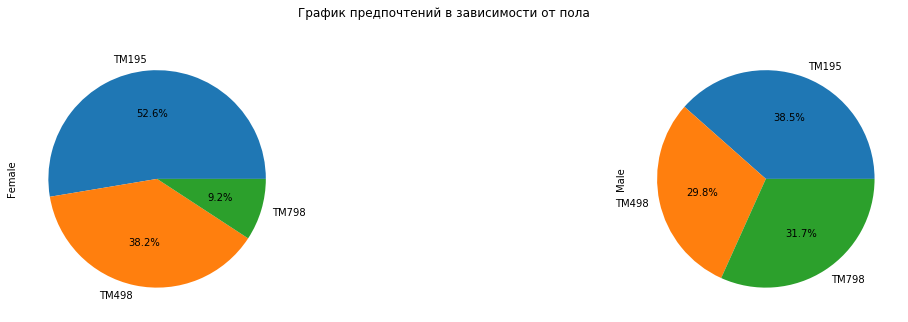

In [41]:
 categorical_compare(contingency, 'График предпочтений в зависимости от пола')

Спрос на беговые дорожки у мужчин имеет следующие распределение 
- ТМ498 - 29.8 %
- ТМ798 - 31.7 %
- ТМ195 - 38.5 %

Спрос на беговые дорожки у женщин имеет следующие распределение
- ТМ798 - 9.2 %
- ТМ498 - 38.2 %
- ТМ195 - 52.6 %

Проверим значимость этих различий 

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [42]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [43]:
do_test(p)

Отвергаем нулевую гипотезу


##### Вывод

Предпочтение мужчин и женщин действительно различны 

#### Анализ возраста пользователей беговых дорожек в разбивки по грейдерному признаку 

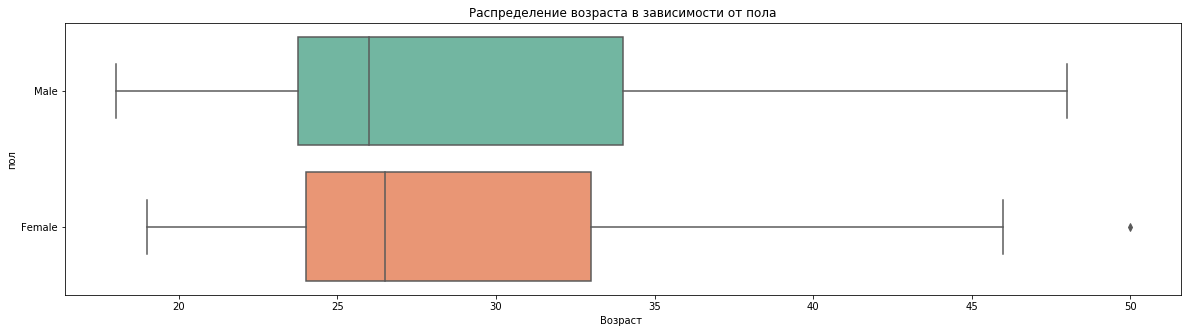

In [44]:
fig = plot.figure(figsize=(20, 5))
sns.boxplot(data=data, x='Age', y='Gender', orient="h", palette="Set2").set(
    title='Распределение возраста в зависимости от пола',  
    xlabel='Возраст ', 
    ylabel='пол'
)
plot.show()

Видно, что средние отличаются несущественно, проверим значимость этих различий (так, как данные содержат выбросы воспользуемся тестом Манна - Уитни)

H0 - Средние идентичны

H1 - Различия существенны 

alpha = 0.05

In [45]:
result = stats.mannwhitneyu(data[data['Gender'] == 'Male']['Age'], data[data['Gender'] == 'Female']['Age'])

In [46]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


#### Вывод

Средний возраст мужнин и женщин, использующих беговую дорожку, идентичен./

### Поле Education

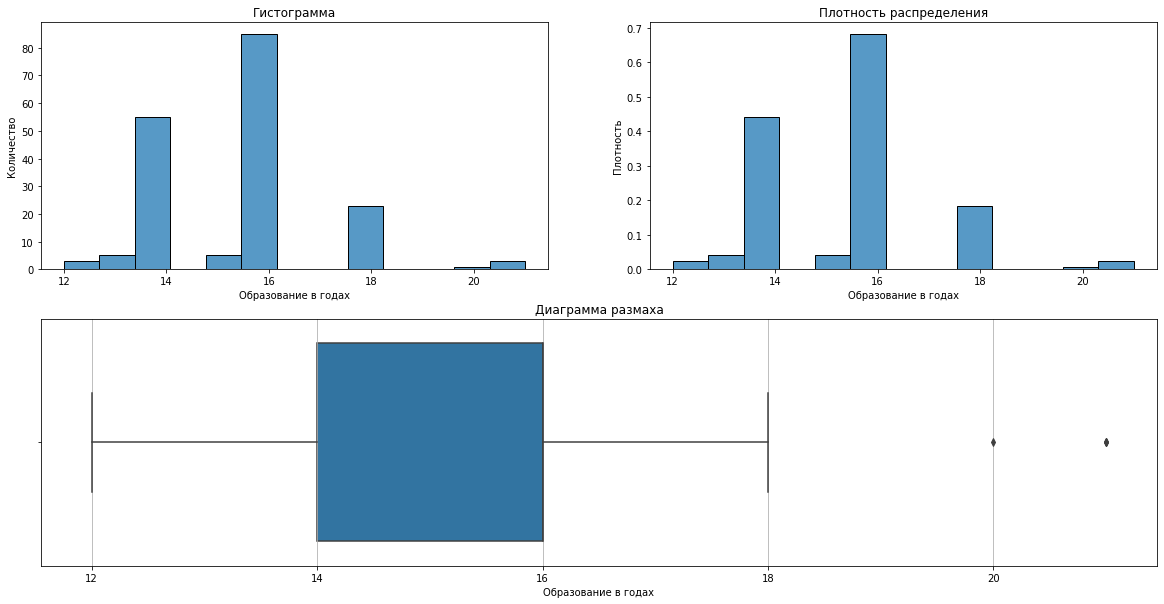

In [47]:
continuous_distribution(data, 'Education', 'Образование в годах')

Образование имеет дискретный график, так как на освоение определенной профессии требуется фиксированное количество лет. Нельзя сказать, что люди с 16 летним образованием, чаще остальных занимаются бегом, возможно таких людей просто больше. 

#### Анализ влияние образования на выбор типа продукта 

In [48]:
len(data[data['Education'] > 18])

4

Так как вопросов немного, просто удалим их 

In [49]:
tmp = data[data['Education'] < 19]

In [50]:
tmp['Education'].unique()

array([14, 15, 12, 13, 16, 18])

Поле содержит только несколько значений, непонятно к какому типу его отнести, поэтому будем проверять гипотезы считая его как категориальной, так и непрерывной переменной.  

#### Анализ в предположении, что Education - категориальная переменная 

In [51]:
contingency = pd.crosstab(tmp['Education'], tmp['Product'])

In [52]:
contingency

Product,TM195,TM498,TM798
Education,,,
12,2,1,0
13,3,2,0
14,30,23,2
15,4,1,0
16,39,31,15
18,2,2,19


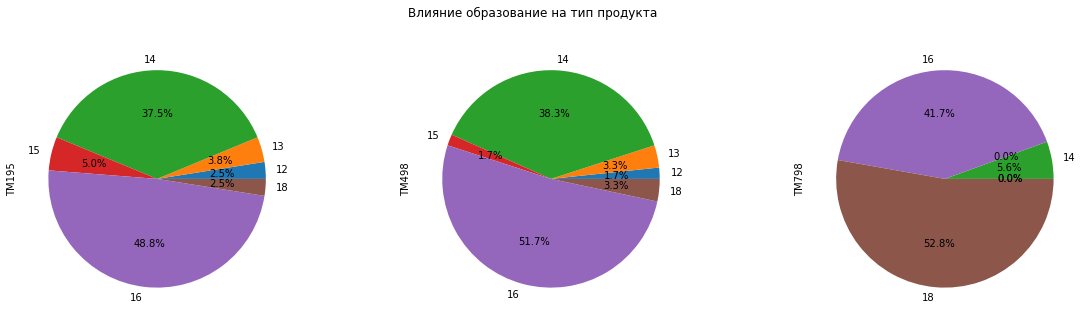

In [53]:
categorical_compare(contingency, 'Влияние образование на тип продукта')

In [54]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [55]:
do_test(p)

Отвергаем нулевую гипотезу


##### Вывод

Видно, что уровень образования влияет на выбор продукта 

#### Анализ в предположении, что Education - непрерывная переменная 

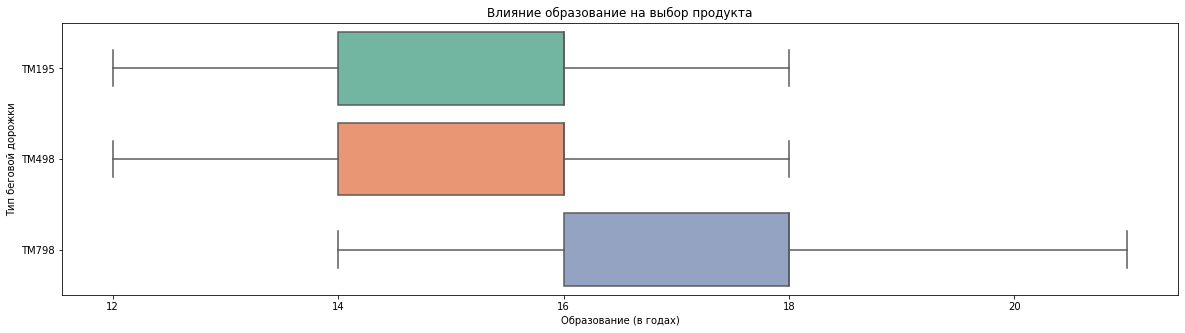

In [56]:
plot.figure(figsize=(20, 5))

tmp = data
tmp['Education'] = data['Education'].astype('float')

sns.boxplot(data=tmp, x='Education', y='Product', orient="h", palette="Set2").set(
    title='Влияние образование на выбор продукта',  
    xlabel='Образование (в годах)', 
    ylabel='Тип беговой дорожки'
)

plot.show()

In [57]:
result = stats.f_oneway(tmp[tmp['Product'] == 'TM195']['Education'], tmp[tmp['Product'] == 'TM498']['Education'], tmp[tmp['Product'] == 'TM798']['Education'])

In [58]:
do_test(result.pvalue)

Отвергаем нулевую гипотезу


##### Вывод

Видно, что уровень образования влияет на выбор продукта 

#### Анализ влияние образования на возраст 

In [59]:
data['Age'].unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 47, 50, 45, 48, 42])

In [60]:
data['Education'].unique()

array([14., 15., 12., 13., 16., 18., 20., 21.])

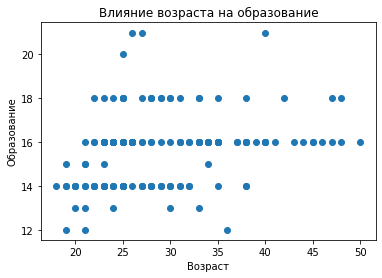

In [61]:
plot.scatter(data['Age'], data['Education'])
plot.title("Влияние возраста на образование")
plot.xlabel("Возраст")
plot.ylabel("Образование")
plot.show()

Линейной зависимости между возрастом и уровнем образованию не наблюдается 

In [62]:
coef, p = stats.spearmanr(data['Age'], data['Education'])

In [63]:
coef

0.3327693831510358

In [64]:
do_test(p)

Отвергаем нулевую гипотезу


По шкале Чеддока признаки имеют слабую положительную связь и эта связь значительна 

#### Анализ влияние образования на пол

In [65]:
data.head()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14.0,Single,3,4,29562,112
1,TM195,19,Male,15.0,Single,2,3,31836,75
2,TM195,19,Female,14.0,Partnered,4,3,30699,66
3,TM195,19,Male,12.0,Single,3,3,32973,85
4,TM195,20,Male,13.0,Partnered,4,2,35247,47


In [66]:
tmp = data[data['Education'] < 19]

#### Анализ в предположении, что Education - категориальная переменная 

In [67]:
contingency = pd.crosstab(tmp['Education'], tmp['Gender'])

In [68]:
contingency

Gender,Female,Male
Education,,
12.0,0,3
13.0,1,4
14.0,30,25
15.0,2,3
16.0,35,50
18.0,7,16


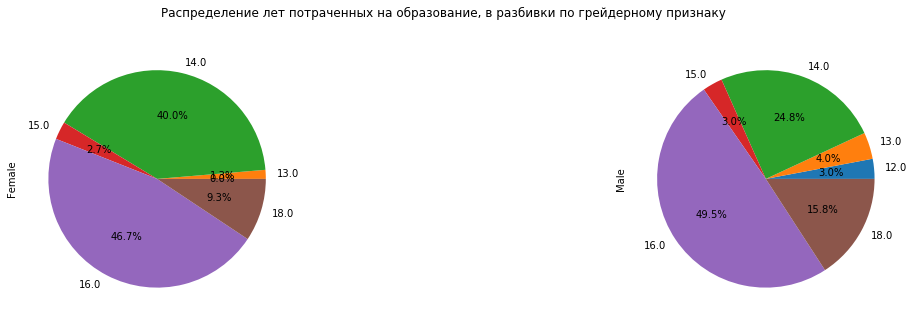

In [69]:
categorical_compare(contingency, 'Распределение лет потраченных на образование, в разбивки по грейдерному признаку')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [70]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [71]:
do_test(p)

Принимаем нулевую гипотезу


##### Вывод

Уровень образования не зависит от пола 

#### Анализ в предположении, что Education - непрерывная переменная 

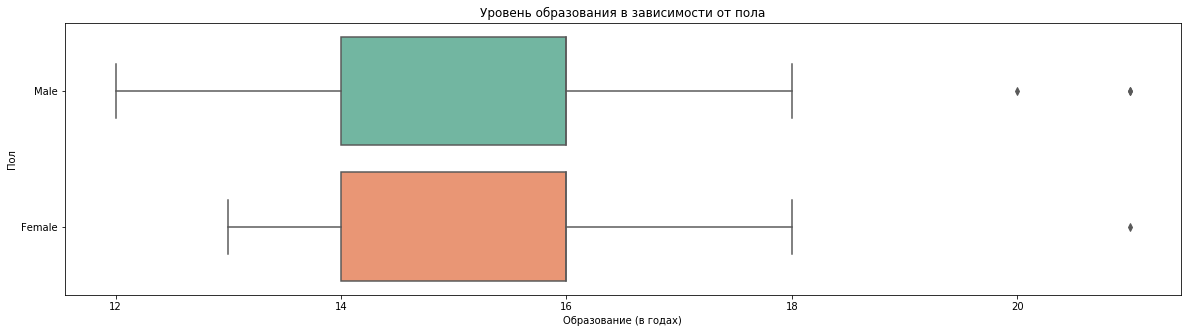

In [72]:
plot.figure(figsize=(20, 5))

tmp = data
tmp['Education'] = data['Education'].astype('float')

sns.boxplot(data=tmp, x='Education', y='Gender', orient="h", palette="Set2").set(
    title='Уровень образования в зависимости от пола',  
    xlabel='Образование (в годах)', 
    ylabel='Пол'
)

plot.show()

H0 - Средние идентичны

H1 - Различия существенны 

alpha = 0.05

In [73]:
result = stats.ttest_ind(data[data['Gender'] == 'Male']['Education'], data[data['Gender'] == 'Female']['Education'])

In [74]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


##### Вывод

Уровень образования не зависит от пола 

### Поле MaritalStatus

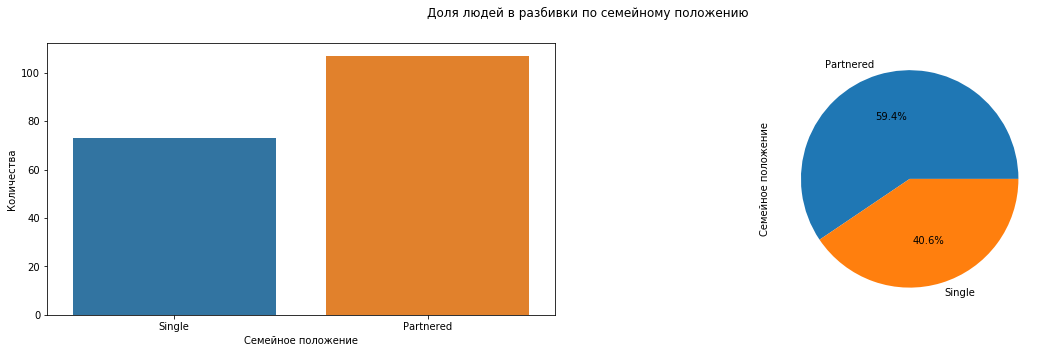

In [75]:
print_categories_variable('MaritalStatus', 'Доля людей в разбивки по семейному положению', 'Семейное положение', 'Количества')

Люди в браке чаще предпочитают бег 

#### Анализ влияние семейного положения на выбор типа продукта 

In [76]:
contingency = pd.crosstab(tmp['MaritalStatus'], tmp['Product'])

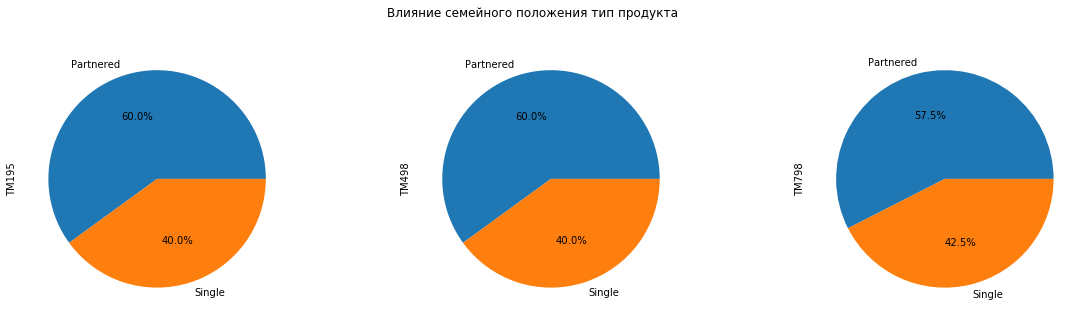

In [77]:
categorical_compare(contingency, 'Влияние семейного положения тип продукта')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [78]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [79]:
do_test(p)

Принимаем нулевую гипотезу


Влияние семейного положение на выбор типа продукта не выявлено

#### Распределение возраста в разбивки по семейному положению 

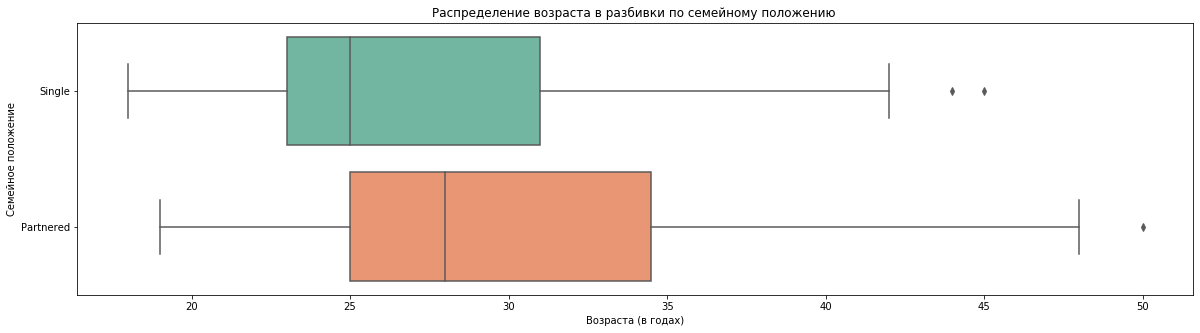

In [80]:
plot.figure(figsize=(20, 5))

sns.boxplot(data=data, x='Age', y='MaritalStatus', orient="h", palette="Set2").set(
    title='Распределение возраста в разбивки по семейному положению ',  
    xlabel='Возраста (в годах)', 
    ylabel='Семейное положение'
)

plot.show()

In [81]:
result = stats.mannwhitneyu(data[data['MaritalStatus'] == 'Single']['Age'], data[data['MaritalStatus'] == 'Partnered']['Age'])

In [82]:
do_test(result.pvalue)

Отвергаем нулевую гипотезу


Логично, что среди людей старшего возраста больше людей в браке. 

#### Распределения семейного положения в разбивки по гендерному признаку 

In [83]:
contingency = pd.crosstab(tmp['MaritalStatus'], tmp['Gender'])

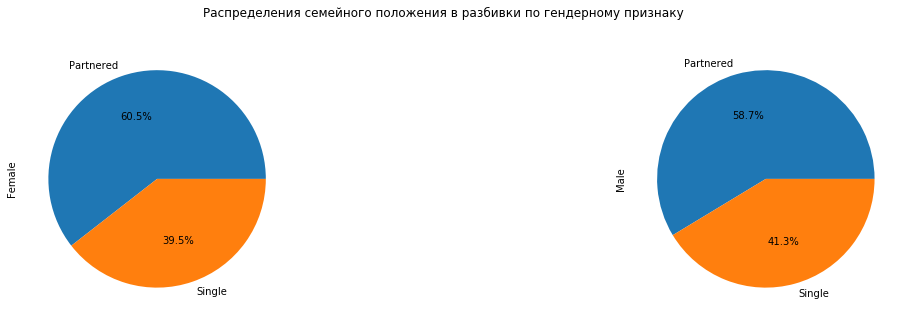

In [84]:
categorical_compare(contingency, 'Распределения семейного положения в разбивки по гендерному признаку')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [85]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [86]:
do_test(p)

Принимаем нулевую гипотезу


Пол не влияет на семейное положение 

#### Анализ влияние семейного положение на образование 

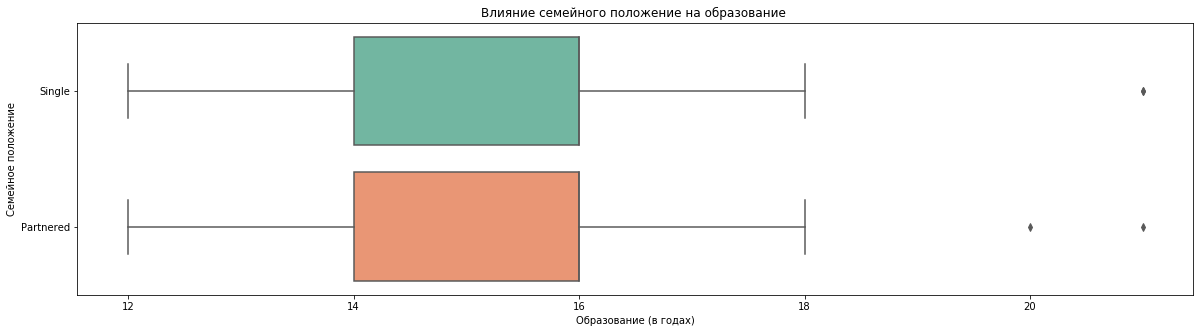

In [87]:
plot.figure(figsize=(20, 5))

sns.boxplot(data=data, x='Education', y='MaritalStatus', orient="h", palette="Set2").set(
    title='Влияние семейного положение на образование ',  
    xlabel='Oбразование (в годах)', 
    ylabel='Семейное положение'
)

plot.show()

In [88]:
result = stats.mannwhitneyu(data[data['MaritalStatus'] == 'Single']['Education'], data[data['MaritalStatus'] == 'Partnered']['Education'])

In [89]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


Семейный статус не влияет на образование 

### Поле Usage

In [90]:
data['Usage'].unique()

array([3, 2, 4, 5, 6, 7])

Поле содержит несколько значений, поэтому его можно рассматривать и как ранговую, и как категориальную переменную

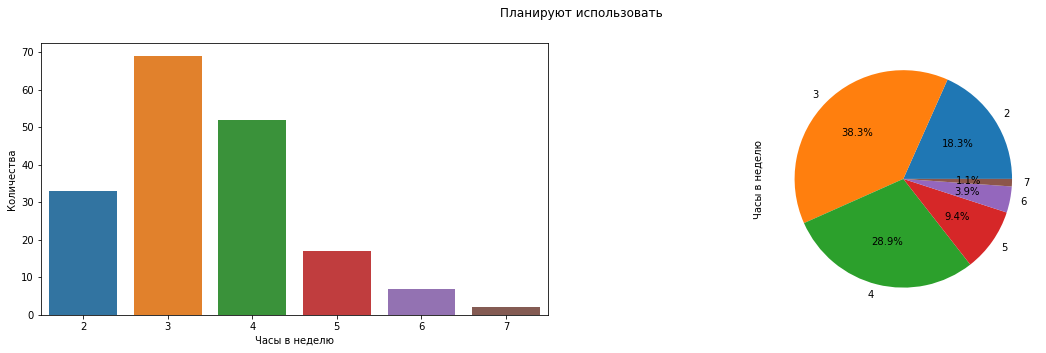

In [91]:
print_categories_variable('Usage', 'Планируют использовать', 'Часы в неделю', 'Количества')

In [92]:
len(data[data['Usage'] == 7])

2

В основном люди планируют планируют бегать 3 часа в неделю и только 2 человека планируют бегать по 7 часов 

#### Анализ выбора типа дорожки в зависимости от планов на использования  

In [93]:
contingency = pd.crosstab(data['Usage'], data['Product'])

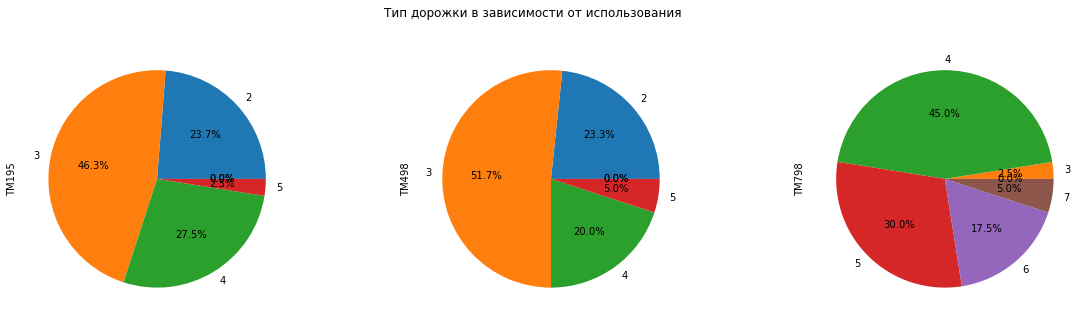

In [94]:
categorical_compare(contingency, 'Тип дорожки в зависимости от использования')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [95]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [96]:
do_test(p)

Отвергаем нулевую гипотезу


##### Вывод

Люди, которые планируют много бегать, предпочитают дорожки типа **TM798**

#### Анализ планов на использование в зависимости от возраста 

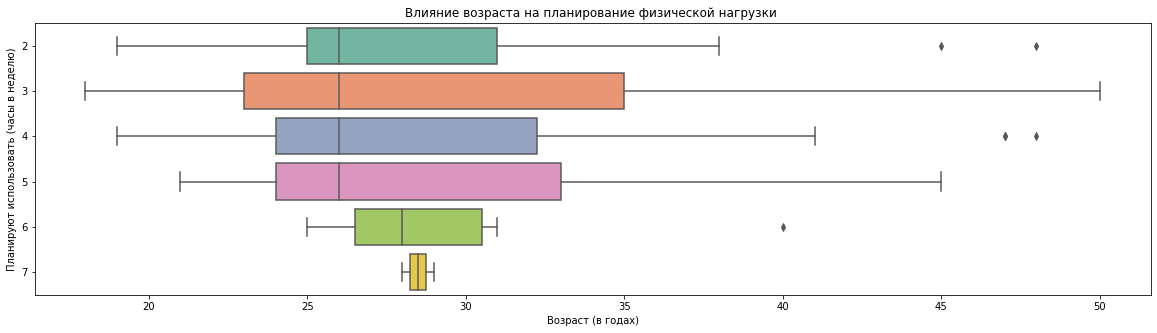

In [97]:
plot.figure(figsize=(20, 5))

sns.boxplot(data=data, x='Age', y='Usage', orient="h", palette="Set2").set(
    title='Влияние возраста на планирование физической нагрузки ',  
    xlabel='Возраст (в годах)', 
    ylabel='Планируют использовать (часы в неделю)'
)

plot.show()

In [98]:
result = stats.f_oneway(data[data['Usage'] == 2]['Age'], data[data['Usage'] == 3]['Age'],
                            data[data['Usage'] == 4]['Age'], data[data['Usage'] == 5]['Age'], data[data['Usage'] == 6]['Age'],
                            data[data['Usage'] == 7]['Age'])

In [99]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


Видно, что планы на использование не зависят от возраста. 

#### Анализ планов на использование в зависимости от пола

In [100]:
contingency = pd.crosstab(data['Usage'], data['Gender'])

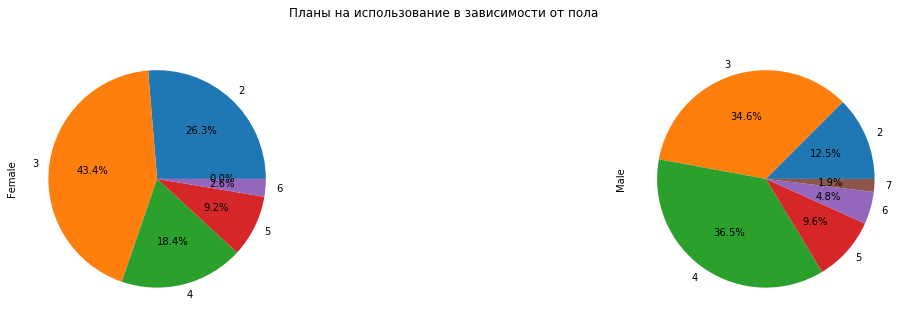

In [101]:
categorical_compare(contingency, 'Планы на использование в зависимости от пола')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [102]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [103]:
do_test(p)

Отвергаем нулевую гипотезу


Мужчины планируют пробегать больше, чем женщины. 

#### Анализ планов на использование в зависимости от образования 

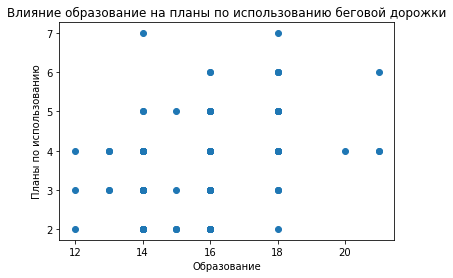

In [104]:
plot.scatter(data['Education'], data['Usage'])
plot.title("Влияние образование на планы по использованию беговой дорожки")
plot.xlabel("Образование")
plot.ylabel("Планы по использованию")
plot.show()

Линейной зависимости между планами на использование и уровнем образованию не наблюдается 

In [105]:
coef, p = stats.spearmanr(data['Education'], data['Usage'])

In [106]:
coef

0.380320907943528

In [107]:
do_test(p)

Отвергаем нулевую гипотезу


По шкале Чеддока признаки имеют умеренную положительную связь и эта связь значительна 

#### Анализ планов на использование в зависимости от семейного положения 

In [108]:
contingency = pd.crosstab(data['Usage'], data['MaritalStatus'])

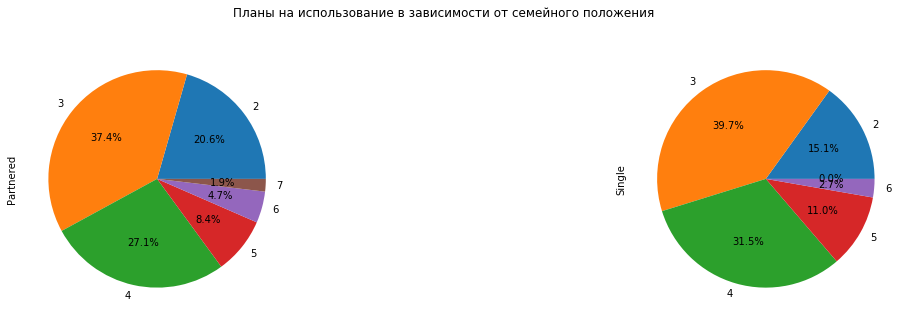

In [109]:
categorical_compare(contingency, 'Планы на использование в зависимости от семейного положения')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [110]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [111]:
do_test(p)

Принимаем нулевую гипотезу


Семейное положение не влияет на планирование физической нагрузки 

### Поле Fitness

In [112]:
data['Fitness'].unique()

array([4, 3, 2, 1, 5])

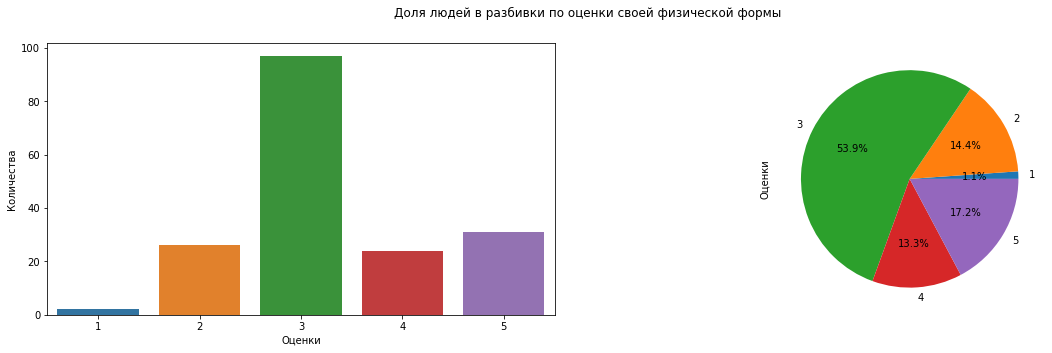

In [113]:
print_categories_variable('Fitness', 'Доля людей в разбивки по оценки своей физической формы', 'Оценки', 'Количества')

В основном люди оценивают свою физическую форму на троечку 

#### Влияние оценки физической формы на тип продукта 

In [114]:
contingency = pd.crosstab(data['Fitness'], data['Product'])

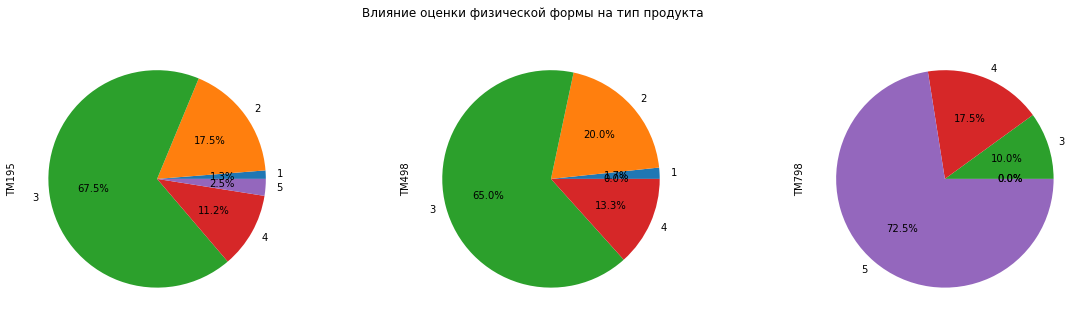

In [115]:
categorical_compare(contingency, 'Влияние оценки физической формы на тип продукта')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [116]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [117]:
do_test(p)

Отвергаем нулевую гипотезу


Люди с хорошей физической формой предпочитают беговые дорожки типа TM798

#### Влияние возраста на оценку физической формы 

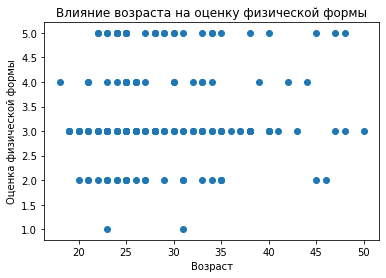

In [118]:
plot.scatter(data['Age'], data['Fitness'])
plot.title("Влияние возраста на оценку физической формы")
plot.xlabel("Возраст")
plot.ylabel("Оценка физической формы")
plot.show()

In [119]:
coef, p = stats.spearmanr(data['Age'], data['Fitness'])

In [120]:
coef

0.063274592297998

In [121]:
do_test(p)

Принимаем нулевую гипотезу


Связь между признаками не обнаружена 

#### Влияние пола на оценку физической формы 

In [124]:
contingency = pd.crosstab(data['Fitness'], data['Gender'])

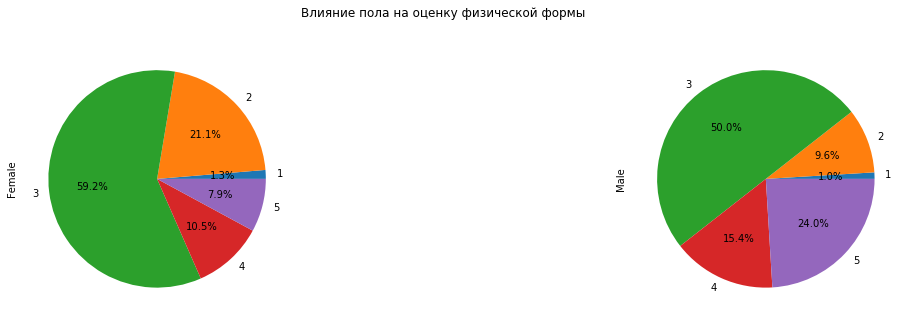

In [125]:
categorical_compare(contingency, 'Влияние пола на оценку физической формы')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [126]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [127]:
do_test(p)

Отвергаем нулевую гипотезу


Мужчины оценивают свою физическую форму выше женщин 

#### Влияние образования на оценку физической формы 

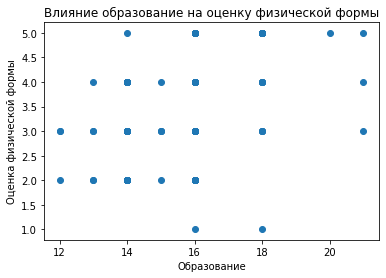

In [129]:
plot.scatter(data['Education'], data['Fitness'])
plot.title("Влияние образование на оценку физической формы")
plot.xlabel("Образование")
plot.ylabel("Оценка физической формы")
plot.show()

In [130]:
coef, p = stats.spearmanr(data['Education'], data['Fitness'])

In [131]:
coef

0.39024637239447596

In [132]:
do_test(p)

Отвергаем нулевую гипотезу


По шкале Чеддока признаки имеют умеренную положительную связь и эта связь значительна

#### Влияние семейного положение на оценку физической формы 

In [134]:
contingency = pd.crosstab(data['Fitness'], data['MaritalStatus'])

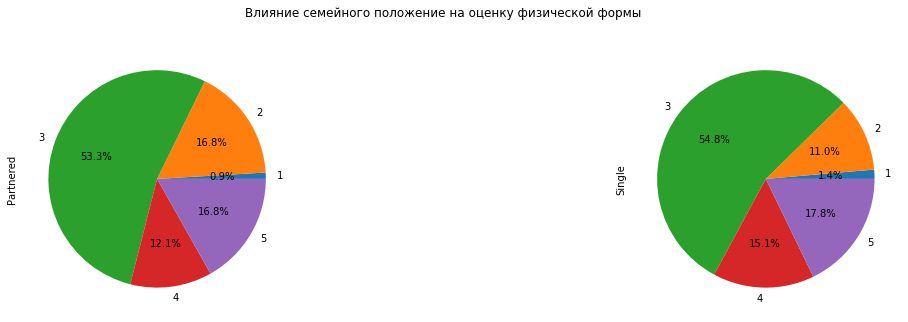

In [135]:
categorical_compare(contingency, 'Влияние семейного положение на оценку физической формы')

H0 - Признаки независимы

H1 - Существует связь между признаками 

alpha = 0.05

In [136]:
c, p, dof, expected = stats.chi2_contingency(contingency)

In [137]:
do_test(p)

Принимаем нулевую гипотезу


Связь между признаками не обнаружена 

#### Влияние планов по использованию на оценку физической формы 

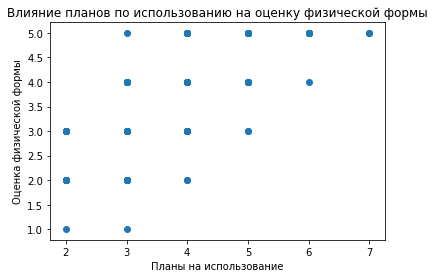

In [139]:
plot.scatter(data['Usage'], data['Fitness'])
plot.title("Влияние планов по использованию на оценку физической формы")
plot.xlabel("Планы на использование")
plot.ylabel("Оценка физической формы")
plot.show()

In [140]:
coef, p = stats.spearmanr(data['Usage'], data['Fitness'])

In [141]:
coef

0.6438167889364456

In [142]:
do_test(p)

Отвергаем нулевую гипотезу


По шкале Чеддока признаки имеют заметную положительную связь и эта связь значительна

### Поле Income

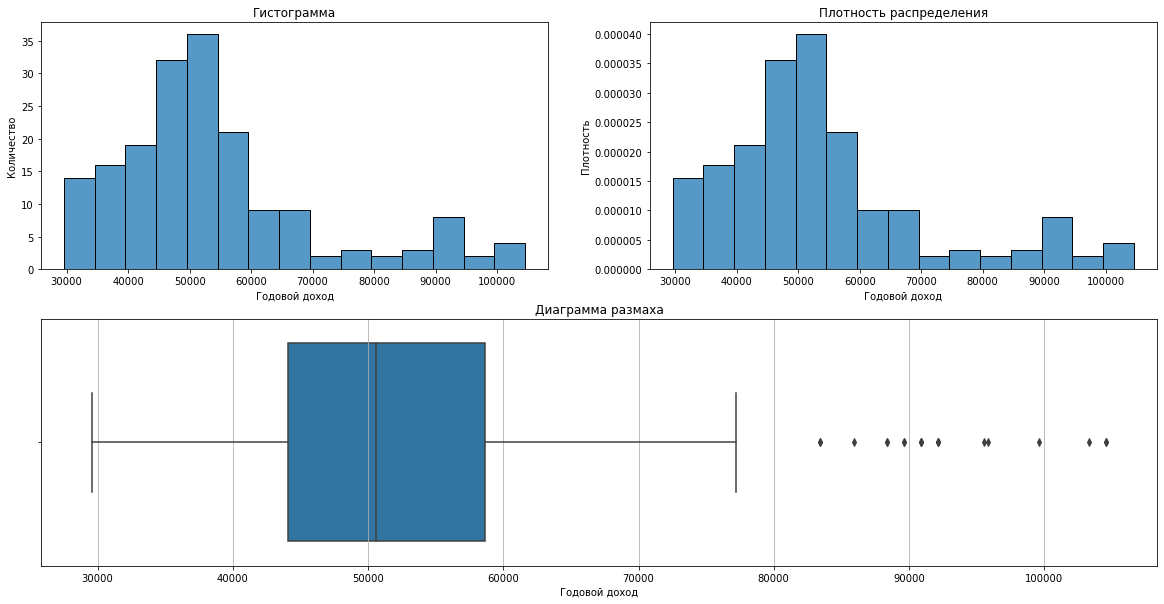

In [145]:
continuous_distribution(data, 'Income', 'Годовой доход')